# Complex Demographic Scenario
- define your own prior
- historical population sizes inference
- time scale, training data, ...

In [7]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
import tskit
import torch

Example from the [snakemake pipeline](https://github.com/kr-colab/popgensbi_snakemake)

In [8]:
### design priors and scenarios
class BaseSimulator:
    def __init__(self, config: dict, default: dict):
        for key in config:
            if key == "class_name": continue
            assert key in default, f"Option {key} not available for simulator"
        for key, default in default.items():
            setattr(self, key, config.get(key, default))
            
class VariablePopulationSize(BaseSimulator):
    """
    Simulate a model with varying population size across multiple time windows.
    The model consists of a single population that undergoes multiple size changes.
    """

    default_config = {
        # FIXED PARAMETERS
        "samples": {"pop": 10},
        "sequence_length": 10e6,
        "mutation_rate": 1.5e-8,
        "num_time_windows": 3,
        # RANDOM PARAMETERS (UNIFORM)
        "pop_sizes": [1e2, 1e5],      # Range for population sizes (log10 space)
        "recomb_rate": [1e-9, 2e-8],  # Range for recombination rate
        # TIME PARAMETERS
        "max_time": 100000,  # Maximum time for population events
        "time_rate": 0.1,    # Rate at which time changes across windows
    }

    def __init__(self, config: dict):
        super().__init__(config, self.default_config)
        # Set up parameters list
        self.parameters = [f"N_{i}" for i in range(self.num_time_windows)] + ["recomb_rate"]
        
        # Create parameter ranges in the same format as AraTha_2epoch
        # Population sizes (in log10 space)
        pop_size_ranges = [[np.log10(self.pop_sizes[0]), np.log10(self.pop_sizes[1])] 
                          for _ in range(self.num_time_windows)]
        # Add recombination rate range
        param_ranges = pop_size_ranges + [self.recomb_rate]
        
        # Set up prior using BoxUniform
        self.prior = BoxUniform(
            low=torch.tensor([r[0] for r in param_ranges]),
            high=torch.tensor([r[1] for r in param_ranges])
        )
        
        # Calculate fixed time points for population size changes
        self.change_times = self._calculate_change_times()

    def _calculate_change_times(self) -> np.ndarray:
        """Calculate the times at which population size changes occur using an exponential spacing."""
        times = [(np.exp(np.log(1 + self.time_rate * self.max_time) * i / 
                       (self.num_time_windows - 1)) - 1) / self.time_rate 
               for i in range(self.num_time_windows)]
        # win = np.logspace(2, np.log10(self.max_time), self.num_time_windows)
        # win[0] = 0
        # times = win
        return np.around(times).astype(int)

    def __call__(self, seed: int = None) -> (tskit.TreeSequence, np.ndarray):
        if seed is not None:
            torch.manual_seed(seed)
        
        min_snps = 400
        max_attempts = 100
        attempt = 0
        
        while attempt < max_attempts:
            # Sample parameters directly from prior (like AraTha_2epoch)
            theta = self.prior.sample().numpy()
            
            # Convert population sizes from log10 space
            pop_sizes = 10 ** theta[:-1]  # All but last element are population sizes
            recomb_rate = theta[-1]  # Last element is recombination rate
            
            # Create demography
            demography = msprime.Demography()
            demography.add_population(name="pop0", initial_size=float(pop_sizes[0]))
            
            # Add population size changes at calculated time intervals
            for i in range(1, len(pop_sizes)):
                demography.add_population_parameters_change(
                    time=self.change_times[i],
                    initial_size=float(pop_sizes[i]),
                    growth_rate=0,
                    population="pop0"
                )

            # Simulate ancestry
            ts = msprime.sim_ancestry(
                samples={"pop0": self.samples["pop"]},
                demography=demography,
                sequence_length=self.sequence_length,
                recombination_rate=recomb_rate,
                random_seed=seed
            )
            
            # Add mutations
            ts = msprime.sim_mutations(ts, rate=self.mutation_rate, random_seed=seed)
            
            # Check if we have enough SNPs after MAF filtering
            geno = ts.genotype_matrix().T
            num_sample = geno.shape[0]
            if (geno==2).any():
                num_sample *= 2
            
            row_sum = np.sum(geno, axis=0)
            keep = np.logical_and.reduce([
                row_sum != 0,
                row_sum != num_sample,
                row_sum > num_sample * 0.05,
                num_sample - row_sum > num_sample * 0.05
            ])
            
            if np.sum(keep) >= min_snps:
                return ts, theta
                
            attempt += 1
            if seed is not None:
                seed += 1
        
        raise RuntimeError(f"Failed to generate tree sequence with at least {min_snps} SNPs after {max_attempts} attempts")


In [25]:
config = {
        # FIXED PARAMETERS
        "samples": {"pop": 20},
        "sequence_length": 1e6,
        "mutation_rate": 1e-8,
        "num_time_windows": 10,
        # RANDOM PARAMETERS (UNIFORM)
        "pop_sizes": [1e2, 1e5],      # Range for population sizes (log10 space)
        "recomb_rate": [1e-9, 2e-8],  # Range for recombination rate
        # TIME PARAMETERS
        "max_time": 100000,  # Maximum time for population events
        "time_rate": 0.1,    # Rate at which time changes across windows
    }
Population = VariablePopulationSize(config)


In [28]:
Population.prior.sample() # N_e and recomb rate sampled from prior

tensor([4.3259e+00, 4.7972e+00, 4.3226e+00, 4.1401e+00, 2.9795e+00, 4.5782e+00,
        3.0883e+00, 4.3397e+00, 3.4602e+00, 2.4058e+00, 1.5656e-08])

In [33]:
ts, theta = Population(seed=42)  # Simulate data with a given seed

In [50]:
ts.allele_frequency_spectrum()

array([0.000e+00, 1.667e-04, 1.014e-04, 8.190e-05, 4.820e-05, 3.890e-05,
       2.270e-05, 1.510e-05, 2.090e-05, 1.910e-05, 5.500e-06, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00])

In [34]:
geno = ts.genotype_matrix().T 
num_sample = geno.shape[0]
if (geno == 2).any():
    num_sample *= 2

row_sum = np.sum(geno, axis=0)
keep = np.logical_and.reduce([
    row_sum != 0,
    row_sum != num_sample,
    row_sum > num_sample * 0.05,
    num_sample - row_sum > num_sample * 0.05
])

geno_filtered = geno[:, keep]
print("Filtered geno shape:", geno_filtered.shape)


Filtered geno shape: (20, 2183)


In [44]:
num_simulations = 100
theta_list = []
x_list = []

for seed in range(num_simulations):
    ts, theta = Population(seed=seed+1)
    geno = ts.genotype_matrix().T
    # Example: use simple summary statistics as observations
    x = np.array([geno.shape[1]])  # e.g., number of SNPs as a toy statistic
    theta_list.append(torch.as_tensor(theta, dtype=torch.float32))
    x_list.append(torch.as_tensor(x, dtype=torch.float32))

theta_tensor = torch.stack(theta_list)  # shape: (num_simulations, num_params)
x_tensor = torch.stack(x_list)          # shape: (num_simulations, num_stats)


In [45]:
from sbi.inference import NPE

inference = NPE(prior=Population.prior)
inference = inference.append_simulations(theta_tensor, x_tensor)
density_estimator = inference.train()
posterior = inference.build_posterior()


 Neural network successfully converged after 190 epochs.

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/yuxinning/Projects/sbi_workshop_Legend2025/notebooks/sbi-logs/NPE_C/2025-11-24T12_02_14.119402' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


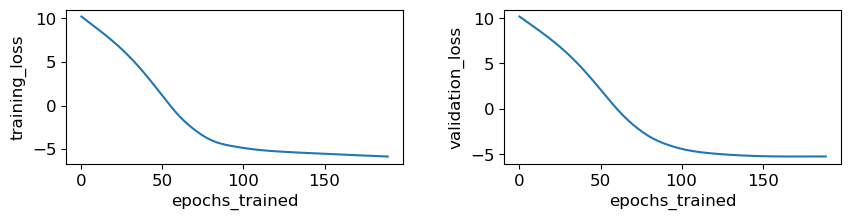

In [46]:
from sbi.analysis import plot_summary

_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)